# Install Stuff

In [1]:
!npm i -g npm
!npm install -g youtube-comment-scraper-cli

/tools/node/bin/npm -> /tools/node/lib/node_modules/npm/bin/npm-cli.js
/tools/node/bin/npx -> /tools/node/lib/node_modules/npm/bin/npx-cli.js
+ npm@6.14.5
added 325 packages from 161 contributors, removed 423 packages and updated 60 packages in 15.342s
npm WARN deprecated request@2.88.2: request has been deprecated, see https://github.com/request/request/issues/3142
/tools/node/bin/youtube-comment-scraper -> /tools/node/lib/node_modules/youtube-comment-scraper-cli/bin/youtube-comment-scraper
+ youtube-comment-scraper-cli@1.0.2
added 114 packages from 94 contributors in 7.33s


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title Key in the VideoID
#@markdown You can get a video id from youtube as such ```https://www.youtube.com/watch?v=<VideoID>```
video_id = 'rAhuD368Ij0'  #@param {type: "string"}


In [0]:
!youtube-comment-scraper $video_id -f csv -o comments.csv

# Import Stuff

In [5]:
!pip install transformers

     |████████████████████████████████| 675kB 2.6MB/s 
     |████████████████████████████████| 3.8MB 13.5MB/s 
     |████████████████████████████████| 890kB 32.7MB/s 
     |████████████████████████████████| 1.1MB 29.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4244d8bdfc883b2474c3292a68f36ac1fbede46a3608d4c4164d1bc0bb352b90
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import pandas as pd
from transformers import pipeline
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm

# Clean text

In [0]:
def deEmojify(inputString):
    string = inputString.encode('ascii', 'ignore').decode('ascii')
    return string
def clean_csv(df):
  df = df.drop(labels=[col for col in df.columns if col != 'text'],axis=1)
  df = df.dropna(subset=['text'])
  df['clean_text'] = df['text'].str.replace(r'\\n',' ')
  df['clean_text'] = df['clean_text'].apply(deEmojify)
  df = df.dropna(subset=['clean_text'])
  df = df[df['clean_text']!='']
  return df

In [0]:
df = pd.read_csv('comments.csv')
df = clean_csv(df)

# Setup model and configuration

In [0]:
class Config:
    MAX_LEN=512
    TRAIN_BATCH_SIZE=16
    VALID_BATCH_SIZE=16
    TOKENIZER = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    CSV_PATH = '../input/complete-tweet-sentiment-extraction-data/tweet_dataset.csv'
    EPOCHS = 5

In [0]:
class CommentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropouts = nn.ModuleList([nn.Dropout(0.15) for _ in range(5)])
        self.l1 = nn.Linear(768,3) # for sentiment
        self.l2 = nn.Linear(768,13) # for emotion
    def forward(self,ids,mask):
        x = self.bert(input_ids=ids,attention_mask=mask)[0]
        for i,dropout in enumerate(self.dropouts):
            if i == 0:
                out_sum = dropout(x)
            else:
                out_sum += dropout(x)
        out = out_sum/len(self.dropouts)
        out = torch.mean(out,dim=1)
        sentiment = self.l1(out)
        emotion = self.l2(out)
        return sentiment,emotion

In [0]:
class TweetDataset:
    """
    Dataset which stores the tweets and returns them as processed features
    """
    def __init__(self, tweet):
        self.tweet = tweet
        self.tokenizer = Config.TOKENIZER
        self.max_len = Config.MAX_LEN
    
    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids),
            'mask':torch.tensor(mask)
        }

In [0]:
def eval_fn(data_loader, model, device):
    model.eval()

    tk0 = tqdm(data_loader, total=len(data_loader))
    s_ls = []
    e_ls = []
    with torch.no_grad():
        for bi, d in enumerate(tk0):

            ids = d["ids"]
            mask = d["mask"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)

            pred_sentiment,pred_emotion= model(
                ids=ids,
                mask=mask,
            )

            pred_sentiment = torch.argmax(torch.softmax(pred_sentiment,dim=-1),dim=-1)
            for pred in pred_sentiment:
              s_ls.append(pred.item())
            pred_emotion = torch.argmax(torch.softmax(pred_emotion,dim=-1),dim=-1)
            for pred in pred_emotion:
              e_ls.append(pred.item())
    return s_ls,e_ls

# Output files

In [80]:
valid_dataset = TweetDataset(
    tweet=df.clean_text.values
)
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=Config.VALID_BATCH_SIZE,
    num_workers=2
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CommentModel()
model.to(device)
model.load_state_dict(torch.load('drive/My Drive/NLP/sentiment/model.bin'))
s_ls,e_ls = eval_fn(valid_data_loader,model,device)

100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


In [0]:
def flipdict(a):
  return dict((v,k) for k,v in a.items())

In [0]:
df['s'] = s_ls
df['e'] = e_ls
emotion_dict = {'anger':0,'boredom':1,'empty':2,'enthusiasm':3,'fun':4,
                'happiness':5,'hate':6,'love':7,'neutral':8,'relief':9,
                'sadness':10,'surprise':11,'worry':12}
emotion_dict = flipdict(emotion_dict)
sentiment_dict = {'negative':0,'neutral':1,'positive':2}
sentiment_dict = flipdict(sentiment_dict)
df['sentiment'] = df['s'].apply(lambda x: sentiment_dict[x])
df['emotion'] = df['e'].apply(lambda x:emotion_dict[x])

In [0]:
def print_test(df,i):
  row = df.iloc[i]
  print(row.clean_text)
  print(row.sentiment)
  print(row.emotion)

In [122]:
print_test(df,5)

Thank u jesus forbourbpm singa roar jesus pnp government to take care of oyr people life safety needs daiky pray jesus blood cover u all pray to him to be safe jesus
positive
love


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def make_pie_chart(df,dict,label):
  sizeList = []
  group = df.groupby(label)
  l = list(set(df[label]))
  for s in l:
    n = group.get_group(s).shape[0]
    sizeList.append(n)
  print(group.size(),"\n")
  plt.pie(sizeList,labels=l,autopct='%1.1f%%')
  plt.title(f'Pie Chart of {label}')
  plt.figure(figsize=(20,20))
  plt.show()

sentiment
negative    145
neutral     156
positive    198
dtype: int64 



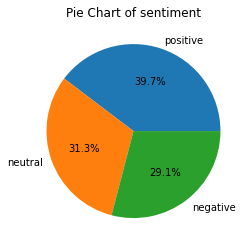

<Figure size 1440x1440 with 0 Axes>

In [119]:
make_pie_chart(df,sentiment_dict,'sentiment')

emotion
happiness     92
hate           2
love          46
neutral      137
relief         1
sadness        5
surprise       2
worry        214
dtype: int64 



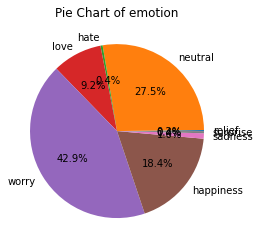

<Figure size 1440x1440 with 0 Axes>

In [120]:
make_pie_chart(df,emotion_dict,'emotion')

# Save output

In [0]:
df.drop(labels=['s','e'],axis=1).to_csv('drive/My Drive/NLP/sentiment/out.csv',index=False)